In [1]:
from numpy.random import seed
seed(101)
from tensorflow import set_random_seed
set_random_seed(101)

import pandas as pd
import numpy as np


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

import os
import cv2

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:

IMAGE_SIZE = 96
IMAGE_CHANNELS = 3

SAMPLE_SIZE = 80000 # the number of images we use from each of the two classes


In [3]:
df_data = pd.read_csv('train_labels.csv')

# removing this image because it caused a training error previously
df_data[df_data['id'] != 'dd6dfed324f9fcb6f93f46f32fc800f2ec196be2']

# removing this image because it's black
df_data[df_data['id'] != '9369c7278ec8bcc6c880d99194de09fc2bd4efbe']


print(df_data.shape)

(220025, 2)


In [4]:
# source: https://www.kaggle.com/gpreda/honey-bee-subspecies-classification

def draw_category_images(col_name,figure_cols, df, IMAGE_PATH):
 
    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(4*figure_cols,4*len(categories))) # adjust size here
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) # figure_cols is also the sample size
        for j in range(0,figure_cols):
            file=IMAGE_PATH + sample.iloc[j]['id'] + '.tif'
            im=cv2.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=16)  
    plt.tight_layout()
    plt.show()
    

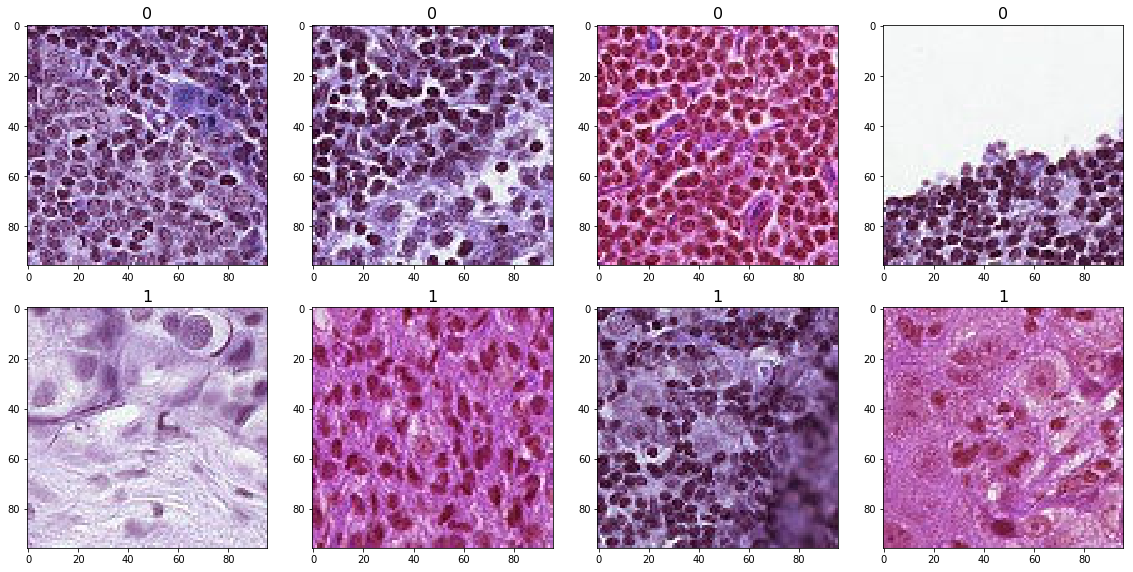

In [5]:
IMAGE_PATH = 'train/' 

draw_category_images('label',4, df_data, IMAGE_PATH)

### Create the Train and Val Sets

In [6]:
# take a random sample of class 0 with size equal to num samples in class 1
df_0 = df_data[df_data['label'] == 0].sample(SAMPLE_SIZE, random_state = 101)
# filter out class 1
df_1 = df_data[df_data['label'] == 1].sample(SAMPLE_SIZE, random_state = 101)

# concat the dataframes
df_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)
# shuffle
df_data = shuffle(df_data)

df_data['label'].value_counts()

1    80000
0    80000
Name: label, dtype: int64

In [7]:
# train_test_split

# stratify=y creates a balanced validation set.
y = df_data['label']

df_train, df_val = train_test_split(df_data, test_size=0.10, random_state=101, stratify=y)

print(df_train.shape)
print(df_val.shape)

(144000, 2)
(16000, 2)


In [8]:
df_train['label'].value_counts()

1    72000
0    72000
Name: label, dtype: int64

In [9]:
df_val['label'].value_counts()

1    8000
0    8000
Name: label, dtype: int64

### Create a Directory Structure

In [10]:
# Create a new directory
base_dir = 'base_dir'
os.mkdir(base_dir)

# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)



# [CREATE FOLDERS INSIDE THE TRAIN AND VALIDATION FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
no_tumor_tissue = os.path.join(train_dir, 'a_no_tumor_tissue')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(train_dir, 'b_has_tumor_tissue')
os.mkdir(has_tumor_tissue)


# create new folders inside val_dir
no_tumor_tissue = os.path.join(val_dir, 'a_no_tumor_tissue')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(val_dir, 'b_has_tumor_tissue')
os.mkdir(has_tumor_tissue)



In [11]:
# check that the folders have been created
os.listdir('base_dir/train_dir')

['a_no_tumor_tissue', 'b_has_tumor_tissue']

### Transfer the images into the folders

In [12]:
# Set the id as the index in df_data
df_data.set_index('id', inplace=True)

In [13]:


# Get a list of train and val images
train_list = list(df_train['id'])
val_list = list(df_val['id'])



# Transfer the train images

for image in train_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    # get the label for a certain image
    target = df_data.loc[image,'label']
    
    # these must match the folder names
    if target == 0:
        label = 'a_no_tumor_tissue'
    if target == 1:
        label = 'b_has_tumor_tissue'
    
    # source path to image
    src = os.path.join('train', fname)
    # destination path to image
    dst = os.path.join(train_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)


# Transfer the val images

for image in val_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    # get the label for a certain image
    target = df_data.loc[image,'label']
    
    # these must match the folder names
    if target == 0:
        label = 'a_no_tumor_tissue'
    if target == 1:
        label = 'b_has_tumor_tissue'
    

    # source path to image
    src = os.path.join('train', fname)
    # destination path to image
    dst = os.path.join(val_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)
    


   

In [14]:
# check how many train images we have in each folder

print(len(os.listdir('base_dir/train_dir/a_no_tumor_tissue')))
print(len(os.listdir('base_dir/train_dir/b_has_tumor_tissue')))


72000
72000


In [15]:
# check how many val images we have in each folder

print(len(os.listdir('base_dir/val_dir/a_no_tumor_tissue')))
print(len(os.listdir('base_dir/val_dir/b_has_tumor_tissue')))


8000
8000


In [16]:
# End of Data Preparation
### ===================================================================================== ###
# Start of Model Building


### Set Up the Generators

In [17]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'
test_path = 'test'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10


train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [18]:
datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')

# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 144000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.


### Create the Model Architecture¶

In [19]:
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3


model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (96, 96, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(2, activation = "softmax"))

model.summary()


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 94, 94, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 92, 92, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 90, 90, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 45, 45, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 43, 43, 64)        18496     
_________________________________________

### Train the Model

In [20]:
model.compile(Adam(lr=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])

In [21]:
# Get the labels that are associated with each index
print(val_gen.class_indices)

{'a_no_tumor_tissue': 0, 'b_has_tumor_tissue': 1}


In [22]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=20, verbose=1,
                   callbacks=callbacks_list)

Epoch 1/20
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
 1600/14400 [==>...........................] - ETA: 2:27 - loss: 0.4337 - acc: 0.8056
Epoch 00001: val_acc improved from -inf to 0.80556, saving model to model.h5
14400/14400 [==============================] - 845s 59ms/step - loss: 0.4312 - acc: 0.8039 - val_loss: 0.4337 - val_acc: 0.8056
Epoch 2/20
 1597/14400 [==>...........................] - ETA: 2:26 - loss: 0.4637 - acc: 0.7978
Epoch 00002: val_acc did not improve from 0.80556
14400/14400 [==============================] - 463s 32ms/step - loss: 0.3371 - acc: 0.8540 - val_loss: 0.4636 - val_acc: 0.7978
Epoch 3/20
 1600/14400 [==>...........................] - ETA: 2:26 - loss: 0.3354 - acc: 0.8658
Epoch 00003: val_acc improved from 0.80556 to 0.86581, saving model to model.h5
14400/14400 [==============================] - 463s 32ms/step - loss: 0.2942 - acc: 0.8755 - val_loss: 0.3354 - val_acc: 0.8658
Epoch 4/20
 1598/14400 [

### Evaluate the model using the val set

In [23]:
# get the metric names so we can use evaulate_generator
model.metrics_names

['loss', 'acc']

In [24]:
# Here the best epoch will be used.

model.load_weights('model.h5')

val_loss, val_acc = \
model.evaluate_generator(test_gen, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_acc:', val_acc)

val_loss: 0.16404875342474004
val_acc: 0.94225


In [42]:
for layer in model.layers:
    print(layer.name)

conv2d
conv2d_1
conv2d_2
max_pooling2d
dropout
conv2d_3
conv2d_4
conv2d_5
max_pooling2d_1
dropout_1
conv2d_6
conv2d_7
conv2d_8
max_pooling2d_2
dropout_2
flatten
dense
dropout_3
dense_1


In [44]:
from keras import backend as K

layer_name = 'dense'

inp = model.input                                           # input placeholder
outputs = model.get_layer(layer_name).output          # all layer outputs
functor = K.function([inp, K.learning_phase()], outputs )

In [56]:
labels=[]
latents=[]

In [58]:
for i in range(len(test_gen)):
   x,y=next(test_gen)
   labels.append(np.argmax(y))
   latents.append(functor([x, 1.]).reshape(-1))

In [60]:
len(latents)

16000

In [ ]:
import numpy as np
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(latents)




In [ ]:
unique_labels = np.unique(labels)

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

fig, ax = plt.subplots()
for i in range(unique_labels.size):
    idxs = [j for j in range(labels.size) if labels[j]==unique_labels[i]]
    ax.scatter(embeddings_test_2d[idxs,0], 
               embeddings_test_2d[idxs,1], 
               c=colors[i],
               label=i,
               alpha=0.7,
               s=10)

ax.legend(scatterpoints=1)
fig.suptitle('T-SNE Visualization of the nodes of the test set',fontsize=12)
fig.set_size_inches(15,9)
plt.show()

### Plot the Training Curves

<Figure size 432x288 with 0 Axes>

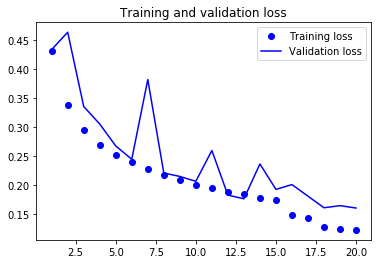

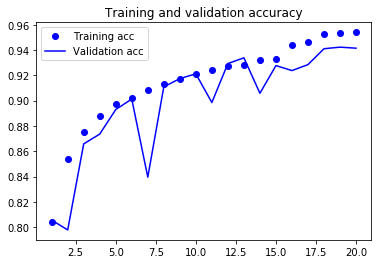

<Figure size 432x288 with 0 Axes>

In [25]:
# display the loss and accuracy curves

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

### Make a prediction on the val set
We need these predictions to calculate the AUC score, print the Confusion Matrix and calculate the F1 score.

In [26]:
# make a prediction
predictions = model.predict_generator(test_gen, steps=len(df_val), verbose=1)

16000/16000 [==============================] - 57s 4ms/step


In [27]:
predictions.shape

(16000, 2)

### A note on Keras class index values

Keras assigns it's own index value (here 0 and 1) to the classes.
It infers the classes based on the folder structure.<br>
Important: These index values may not match the index values we were given in the **train_labels.csv** file.

I've used 'a' and 'b' folder name pre-fixes to get keras to assign index values to match what
was in the train_labels.csv file - I guessed that keras is assigning the index value based on
folder name alphabetical order.

In [28]:
# This is how to check what index keras has internally assigned to each class. 
test_gen.class_indices

{'a_no_tumor_tissue': 0, 'b_has_tumor_tissue': 1}

In [29]:
# Put the predictions into a dataframe.
# The columns need to be oredered to match the output of the previous cell

df_preds = pd.DataFrame(predictions, columns=['no_tumor_tissue', 'has_tumor_tissue'])

df_preds.head()

,no_tumor_tissue,has_tumor_tissue
0,0.995506,0.004494
1,0.984513,0.015487
2,0.796340,0.203660
3,0.997773,0.002227
4,0.875072,0.124928


In [30]:
# Get the true labels
y_true = test_gen.classes

# Get the predicted labels as probabilities
y_pred = df_preds['has_tumor_tissue']


### What is the AUC Score?

In [31]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_true, y_pred)

0.9852949296874999

### Create a Confusion Matrix

In [32]:
# Source: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [33]:
# Get the labels of the test images.

test_labels = test_gen.classes

In [34]:
test_labels.shape

(16000,)

In [35]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [36]:
# Print the label associated with each class
test_gen.class_indices

{'a_no_tumor_tissue': 0, 'b_has_tumor_tissue': 1}

Confusion matrix, without normalization
[[7446  554]
 [ 370 7630]]


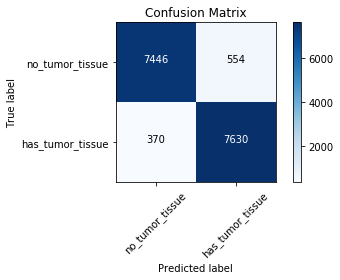

In [37]:
# Define the labels of the class indices. These need to match the 
# order shown above.
cm_plot_labels = ['no_tumor_tissue', 'has_tumor_tissue']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

### Create a Classification Report

In [38]:
from sklearn.metrics import classification_report

# Generate a classification report

# For this to work we need y_pred as binary labels not as probabilities
y_pred_binary = predictions.argmax(axis=1)

report = classification_report(y_true, y_pred_binary, target_names=cm_plot_labels)

print(report)


                  precision    recall  f1-score   support

 no_tumor_tissue       0.95      0.93      0.94      8000
has_tumor_tissue       0.93      0.95      0.94      8000

        accuracy                           0.94     16000
       macro avg       0.94      0.94      0.94     16000
    weighted avg       0.94      0.94      0.94     16000



**Recall **= Given a class, will the classifier be able to detect it?<br>
**Precision **= Given a class prediction from a classifier, how likely is it to be correct?<br>
**F1 Score** = The harmonic mean of the recall and precision. Essentially, it punishes extreme values.

From the confusion matrix and classification report we see that our model is equally good at detecting both classes.